In [2]:
from tensorflow.keras import layers, Model
from matplotlib import pyplot as plt
import nibabel as nib
import numpy as np
import glob
from tqdm import tqdm
import os

In [3]:
class AutoEncoder3DOld: # Works but it uses 2d convolutional layers >:(
    def __init__(self, input_shape):
        # Encoder
        encoder_input = layers.Input(shape=input_shape)
        x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(encoder_input)
        x = layers.MaxPooling2D((2, 2), padding="same")(x)
        x = layers.Dropout(0.1)(x)
        encoded = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(x)
        encoded = layers.MaxPooling2D((2, 2), padding="same")(encoded)

        self.encoder = Model(encoder_input, encoded, name="encoder")

        # Decoder
        decoder_input = layers.Input(shape=(64, 64, 8))  # Shape of encoded latent space
        x = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(decoder_input)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(x)
        x = layers.UpSampling2D((2, 2))(x)
        decoded = layers.Conv2D(170, (3, 3), activation="relu", padding="same")(x)

        self.decoder = Model(decoder_input, decoded, name="decoder")

        # Full Autoencoder (combine encoder and decoder)
        autoencoder_input = encoder_input
        autoencoder_output = self.decoder(self.encoder(encoder_input))
        self.autoencoder = Model(autoencoder_input, autoencoder_output, name="autoencoder")

        self.autoencoder.compile(loss='mean_squared_error', optimizer='adam')
        self.autoencoder.summary()

        return

    def train(self, x_train, epochs=2, batch_size=16):
        history = self.autoencoder.fit(
            x_train, x_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.2
        )
        return history

In [44]:

class AutoEncoder3D:
    def __init__(self, input_shape):
        # Encoder
        encoder_input = layers.Input(shape=input_shape)
        x = layers.Conv3D(4, (3, 3, 3), activation="relu", padding="same")(encoder_input)
        x = layers.MaxPooling3D((2, 2, 2), padding="same")(x)  # Downscale
        x = layers.Dropout(0.1)(x)
        x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(x)
        x = layers.MaxPooling3D((2, 2, 2), padding="same")(x)  # Further downscale
        
        x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(x)
        x = layers.MaxPooling3D((2, 2, 2), padding="same")(x)  # Further downscale

        x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(x)  # Latent space
        encoded = layers.MaxPooling3D((2, 2, 2), padding="same")(x)  # Final downscale for compact latent space

        self.encoder = Model(encoder_input, encoded, name="encoder")

        # Decoder
        #decoder_input = layers.Input(shape=(16, 16, 11, 8))  # Adjust latent space shape (smaller)
        latent_shape = self.encoder.output_shape[1:]  # Exclude batch size (Get the latent shape dynamically)
        decoder_input = layers.Input(shape=latent_shape)  # Use dynamic latent shape

        x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(decoder_input)
        x = layers.UpSampling3D((2, 2, 2))(x)  # Upscale
        x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(x)
        
        x = layers.UpSampling3D((2, 2, 2))(x)  # Upscale
        x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(x)

        x = layers.UpSampling3D((2, 2, 2))(x)  # Upscale
        x = layers.Conv3D(4, (3, 3, 3), activation="relu", padding="same")(x)
        x = layers.UpSampling3D((2, 2, 2))(x)  # Final upscale to original shape
        decoded = layers.Conv3D(1, (3, 3, 3), activation="sigmoid", padding="same")(x)  # Sigmoid for [0, 1] range output

        self.decoder = Model(decoder_input, decoded, name="decoder")

        # Full Autoencoder (combine encoder and decoder)
        autoencoder_input = encoder_input
        autoencoder_output = self.decoder(self.encoder(encoder_input))
        self.autoencoder = Model(autoencoder_input, autoencoder_output, name="autoencoder")

        # Compile the autoencoder
        self.autoencoder.compile(loss='mean_squared_error', optimizer='adam')
        self.autoencoder.summary()

    def train(self, x_train, epochs=2, batch_size=16):
        history = self.autoencoder.fit(
            x_train, x_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.2
        )
        return history

    def encode(self, x):
        """Encode input data x into its latent space representation."""
        return self.encoder.predict(x)

    def decode(self, y):
        """Decode latent space representation y into the original data space."""
        return self.decoder.predict(y)

In [45]:
scan_paths = glob.glob("C:/Users/PieHu/Documents/GitHub/DementiaMRI/Data/Pre-processed/Scaled and padded/**/*.nii", recursive=True)
# scan_paths = glob.glob("C:/Users/ogaboga/*.nii", recursive=True)

scans = []
for path in tqdm(scan_paths, desc="Loading scans"):
    path = path.replace("\\","/")
    scans.append(nib.load(path).get_fdata())
scans = np.array(scans)
scans.shape

Loading scans: 0it [00:00, ?it/s]


(0,)

In [5]:
path = r"C:\Users\kiran\Documents\_UIS\sem6\BACH\Data\very_spatial_norm"
scans = []
scam_count_xd = 10
for file_name in os.listdir(path):
    if file_name.endswith('.nii.gz'):
        file_path = os.path.join(path, file_name)
        img = nib.load(file_path)
        data = img.get_fdata()
        scans.append(data)

        print(file_name[0:10], end="|")
        if len(scans) > scam_count_xd:
            break

scans = np.array(scans)
scans.shape

100_sub-AD|101_sub-AD|102_sub-AD|103_sub-AD|104_sub-AD|105_sub-AD|106_sub-AD|107_sub-AD|108_sub-AD|109_sub-AD|110_sub-AD|

(11, 208, 240, 256)

In [47]:
input_shape = list(scans.shape[1:])
input_shape.append(1)
autoencoder = AutoEncoder3D(input_shape)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 208, 240, 256,  │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 26, 30, 32, 8)  │         2,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 208, 240, 256,  │         4,449 │
│                                 │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - loss: 11762.8242 - val_loss: 12625.3516
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 11722.0557 - val_loss: 12621.2832
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 11718.3799 - val_loss: 12620.7539
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 11717.8115 - val_loss: 12620.6562
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 11717.7139 - val_loss: 12620.6445
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 11717.7041 - val_loss: 12620.6484
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 11717.7080 - val_loss: 12620.6514
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 11717.7139 - val_loss: 12620.6543
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 11717.7158 - val_loss: 12620.6562
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 11717.7158 - val_loss: 12620.6562


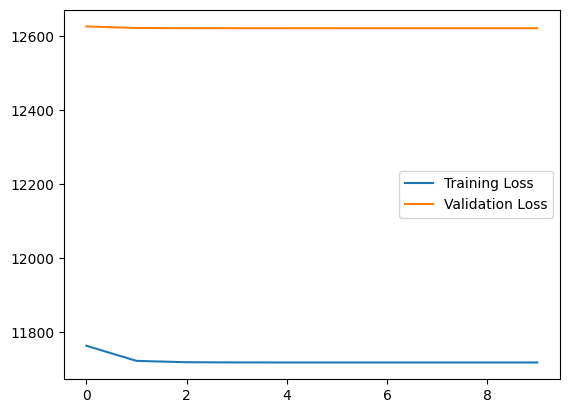

In [48]:
history = autoencoder.train(scans[:8], epochs=10, batch_size=8)

# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


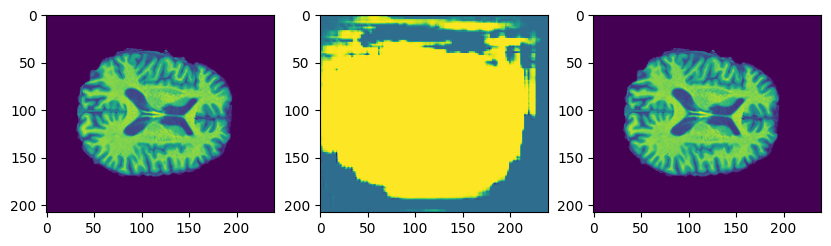

In [41]:
test_idx = 9
slice = 150
latent = autoencoder.encoder.predict(scans[test_idx:test_idx+1])
recon = autoencoder.decoder.predict(latent)

fix, ax = plt.subplots(1,3,figsize=(10,30))
ax[0].imshow(scans[test_idx][:,:,slice])
ax[1].imshow(recon[0,:,:,slice])
ax[2].imshow(scans[test_idx][:,:,slice]-recon[0].reshape(208, 240, 256)[:,:,slice])

### DEPRESSION
https://youtu.be/MnIRAGodAXA?t=301

In [6]:
class AutoEncoder3DTest:
    def __init__(self, input_shape):
        # Encoder
        encoder_input = layers.Input(shape=input_shape)
        
        # Block 1
        x = layers.Conv3D(16, (3, 3, 3), activation="relu", padding="same")(encoder_input)
        x = layers.Conv3D(16, (3, 3, 3), activation="relu", padding="same")(x)
        x = layers.MaxPooling3D((2, 2, 2), padding="same")(x)

        # Block 2
        x = layers.Conv3D(32, (3, 3, 3), activation="relu", padding="same")(x)
        x = layers.Conv3D(32, (3, 3, 3), activation="relu", padding="same")(x)
        x = layers.MaxPooling3D((2, 2, 2), padding="same")(x)

        # Block 3
        x = layers.Conv3D(64, (3, 3, 3), activation="relu", padding="same")(x)
        x = layers.Conv3D(64, (3, 3, 3), activation="relu", padding="same")(x)
        encoded = layers.MaxPooling3D((2, 2, 2), padding="same")(x)  # Latent space

        self.encoder = Model(encoder_input, encoded, name="encoder")

        # Decoder
        latent_shape = self.encoder.output_shape[1:]
        decoder_input = layers.Input(shape=latent_shape)

        # Block 3
        x = layers.Conv3D(64, (3, 3, 3), activation="relu", padding="same")(decoder_input)
        x = layers.Conv3D(64, (3, 3, 3), activation="relu", padding="same")(x)
        x = layers.UpSampling3D((2, 2, 2))(x)

        # Block 2
        x = layers.Conv3D(32, (3, 3, 3), activation="relu", padding="same")(x)
        x = layers.Conv3D(32, (3, 3, 3), activation="relu", padding="same")(x)
        x = layers.UpSampling3D((2, 2, 2))(x)

        # Block 1
        x = layers.Conv3D(16, (3, 3, 3), activation="relu", padding="same")(x)
        x = layers.Conv3D(16, (3, 3, 3), activation="relu", padding="same")(x)
        x = layers.UpSampling3D((2, 2, 2))(x)

        # Output Layer
        decoded = layers.Conv3D(1, (3, 3, 3), activation="sigmoid", padding="same")(x)

        self.decoder = Model(decoder_input, decoded, name="decoder")

        # Full Autoencoder
        autoencoder_input = encoder_input
        autoencoder_output = self.decoder(self.encoder(autoencoder_input))
        self.autoencoder = Model(autoencoder_input, autoencoder_output, name="autoencoder")

        # Compile the autoencoder
        self.autoencoder.compile(loss='mean_squared_error', optimizer='adam')
        self.autoencoder.summary()
    
    def train(self, x_train, epochs=2, batch_size=16):
        history = self.autoencoder.fit(
            x_train, x_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.2
        )
        return history

    def encode(self, x):
        """Encode input data x into its latent space representation."""
        return self.encoder.predict(x)

    def decode(self, y):
        """Decode latent space representation y into the original data space."""
        return self.decoder.predict(y)



Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 208, 240, 256,  │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 26, 30, 32, 64) │       214,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 208, 240, 256,  │       325,521 │
│                                 │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 540,449 (2.06 MB)

 Trainable params: 540,449 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 48s 48s/step - loss: 15658.1025 - val_loss: 10953.3652
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 44s 44s/step - loss: 15641.4512 - val_loss: 10953.4512


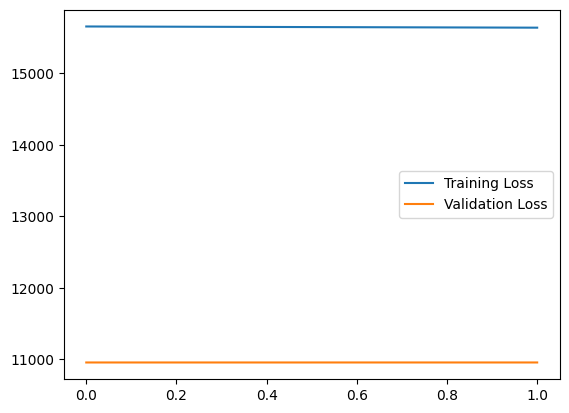

In [7]:
input_shape = list(scans.shape[1:])
input_shape.append(1)
autoencoder = AutoEncoder3DTest(input_shape)


history = autoencoder.train(scans[:3], epochs=2, batch_size=8)

# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


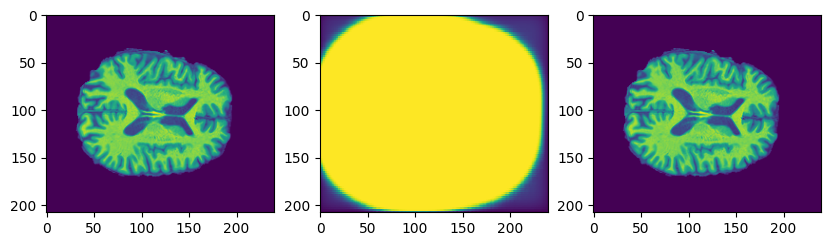

In [8]:
test_idx = 9
slice = 150
latent = autoencoder.encoder.predict(scans[test_idx:test_idx+1])
recon = autoencoder.decoder.predict(latent)

fix, ax = plt.subplots(1,3,figsize=(10,30))
ax[0].imshow(scans[test_idx][:,:,slice])
ax[1].imshow(recon[0,:,:,slice])
ax[2].imshow(scans[test_idx][:,:,slice]-recon[0].reshape(208, 240, 256)[:,:,slice])

In [9]:
class Simple3DAutoencoder:
    def __init__(self, input_shape):
        # Encoder
        encoder_input = layers.Input(shape=input_shape)
        x = layers.Conv3D(32, (3, 3, 3), activation="relu", padding="same")(encoder_input)
        x = layers.MaxPooling3D((2, 2, 2), padding="same")(x)
        x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(x)
        x = layers.MaxPooling3D((2, 2, 2), padding="same")(x)
        x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(x)
        encoded = layers.MaxPooling3D((2, 2, 2), padding="same")(x)  # Latent space

        self.encoder = Model(encoder_input, encoded, name="encoder")

        # Decoder
        latent_shape = self.encoder.output_shape[1:]
        decoder_input = layers.Input(shape=latent_shape)
        x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(decoder_input)
        x = layers.UpSampling3D((2, 2, 2))(x)
        x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(x)
        x = layers.UpSampling3D((2, 2, 2))(x)
        x = layers.Conv3D(32, (3, 3, 3), activation="relu", padding="same")(x)
        x = layers.UpSampling3D((2, 2, 2))(x)
        decoded = layers.Conv3D(1, (3, 3, 3), activation="sigmoid", padding="same")(x)  # Output layer

        self.decoder = Model(decoder_input, decoded, name="decoder")

        # Full Autoencoder
        autoencoder_input = encoder_input
        autoencoder_output = self.decoder(self.encoder(autoencoder_input))
        self.autoencoder = Model(autoencoder_input, autoencoder_output, name="autoencoder")

        # Compile the autoencoder
        self.autoencoder.compile(optimizer="adam", loss="mean_squared_error")
        self.autoencoder.summary()
    
    def train(self, x_train, epochs=2, batch_size=16):
        history = self.autoencoder.fit(
            x_train, x_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.2
        )
        return history

    def encode(self, x):
        """Encode input data x into its latent space representation."""
        return self.encoder.predict(x)

    def decode(self, y):
        """Decode latent space representation y into the original data space."""
        return self.decoder.predict(y)


In [10]:
input_shape = list(scans.shape[1:])
input_shape.append(1)
autoencoder = Simple3DAutoencoder(input_shape)


history = autoencoder.train(scans[:8], epochs=3, batch_size=8)

# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

test_idx = 9
slice = 150
latent = autoencoder.encoder.predict(scans[test_idx:test_idx+1])
recon = autoencoder.decoder.predict(latent)

fix, ax = plt.subplots(1,3,figsize=(10,30))
ax[0].imshow(scans[test_idx][:,:,slice])
ax[1].imshow(recon[0,:,:,slice])
ax[2].imshow(scans[test_idx][:,:,slice]-recon[0].reshape(208, 240, 256)[:,:,slice])

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 208, 240, 256,  │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 26, 30, 32, 8)  │         9,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 208, 240, 256,  │        11,281 │
│                                 │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,833 (81.38 KB)

 Trainable params: 20,833 (81.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3


ResourceExhaustedError: Graph execution error:

Detected at node autoencoder_1/decoder_1/up_sampling3d_5_1/Repeat_2/Tile defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\kiran\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\kiran\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "c:\Users\kiran\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start

  File "c:\Users\kiran\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\kiran\anaconda3\Lib\asyncio\windows_events.py", line 321, in run_forever

  File "c:\Users\kiran\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\Users\kiran\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\Users\kiran\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "c:\Users\kiran\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue

  File "c:\Users\kiran\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one

  File "c:\Users\kiran\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell

  File "c:\Users\kiran\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request

  File "c:\Users\kiran\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "c:\Users\kiran\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\kiran\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell

  File "c:\Users\kiran\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell

  File "c:\Users\kiran\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\kiran\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async

  File "c:\Users\kiran\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes

  File "c:\Users\kiran\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code

  File "C:\Users\kiran\AppData\Local\Temp\ipykernel_23520\3925079844.py", line 6, in <module>

  File "C:\Users\kiran\AppData\Local\Temp\ipykernel_23520\3966098532.py", line 37, in train

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 51, in train_step

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 899, in __call__

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 182, in call

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 584, in call

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 899, in __call__

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 182, in call

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 584, in call

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 899, in __call__

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\layers\reshaping\up_sampling3d.py", line 99, in call

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\layers\reshaping\up_sampling3d.py", line 131, in _resize_volumes

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\ops\numpy.py", line 4694, in repeat

  File "c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1837, in repeat

OOM when allocating tensor with shape[6,208,240,128,2,32] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node autoencoder_1/decoder_1/up_sampling3d_5_1/Repeat_2/Tile}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_9924]

In [13]:
class AutoEncoder3D:
    def __init__(self, input_shape):
        # Encoder
        encoder_input = layers.Input(shape=input_shape)
        
        # Block 1: CNN, BatchNorm, LeakyReLU, MaxPooling3D
        x = layers.Conv3D(32, (3, 3, 3), padding="same")(encoder_input)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.MaxPooling3D((2, 2, 2), padding="same")(x)
        
        # Block 2: CNN, BatchNorm, LeakyReLU, MaxPooling3D
        x = layers.Conv3D(64, (3, 3, 3), padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.MaxPooling3D((2, 2, 2), padding="same")(x)

        # Block 3: CNN, BatchNorm, LeakyReLU, MaxPooling3D
        x = layers.Conv3D(128, (3, 3, 3), padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        encoded = layers.MaxPooling3D((2, 2, 2), padding="same")(x)  # Latent space
        
        self.encoder = Model(encoder_input, encoded, name="encoder")
        
        # Decoder
        latent_shape = self.encoder.output_shape[1:]
        decoder_input = layers.Input(shape=latent_shape)
        
        # Block 1: Deconvolution, BatchNorm, LeakyReLU, UpSampling3D
        x = layers.Conv3D(128, (3, 3, 3), padding="same")(decoder_input)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.UpSampling3D((2, 2, 2))(x)
        
        # Block 2: Deconvolution, BatchNorm, LeakyReLU, UpSampling3D
        x = layers.Conv3D(64, (3, 3, 3), padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.UpSampling3D((2, 2, 2))(x)
        
        # Block 3: Deconvolution, BatchNorm, LeakyReLU, UpSampling3D
        x = layers.Conv3D(32, (3, 3, 3), padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.UpSampling3D((2, 2, 2))(x)
        
        # Output layer: Conv3D with sigmoid activation
        decoded = layers.Conv3D(1, (3, 3, 3), activation="sigmoid", padding="same")(x)

        self.decoder = Model(decoder_input, decoded, name="decoder")
        
        # Full Autoencoder Model
        autoencoder_input = encoder_input
        autoencoder_output = self.decoder(self.encoder(autoencoder_input))
        self.autoencoder = Model(autoencoder_input, autoencoder_output, name="autoencoder")
        
        # Compile the model
        self.autoencoder.compile(optimizer="adam", loss="mean_squared_error")
        self.autoencoder.summary()
        
    def train(self, x_train, epochs=2, batch_size=16):
        history = self.autoencoder.fit(
            x_train, x_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.2
        )
        return history

    def encode(self, x):
        """Encode input data x into its latent space representation."""
        return self.encoder.predict(x)

    def decode(self, y):
        """Decode latent space representation y into the original data space."""
        return self.decoder.predict(y)


In [14]:
input_shape = list(scans.shape[1:])
input_shape.append(1)
autoencoder = AutoEncoder3D(input_shape)


history = autoencoder.train(scans[:3], epochs=3, batch_size=8)

# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

test_idx = 9
slice = 150
latent = autoencoder.encoder.predict(scans[test_idx:test_idx+1])
recon = autoencoder.decoder.predict(latent)

fix, ax = plt.subplots(1,3,figsize=(10,30))
ax[0].imshow(scans[test_idx][:,:,slice])
ax[1].imshow(recon[0,:,:,slice])
ax[2].imshow(scans[test_idx][:,:,slice]-recon[0].reshape(208, 240, 256)[:,:,slice])

c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 208, 240, 256,  │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 26, 30, 32,     │       278,464 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 208, 240, 256,  │       720,833 │
│                                 │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 999,297 (3.81 MB)

 Trainable params: 998,401 (3.81 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/10


RuntimeError: pybind11::error_already_set: MISMATCH of original and normalized active exception types: ORIGINAL ResourceExhaustedError REPLACED BY KeyboardInterrupt: <EMPTY MESSAGE>

At:
  c:\Users\kiran\anaconda3\Lib\site-packages\tensorflow\python\framework\errors_impl.py(377): __init__
  c:\Users\kiran\anaconda3\Lib\site-packages\tensorflow\python\eager\execute.py(53): quick_execute
  c:\Users\kiran\anaconda3\Lib\site-packages\tensorflow\python\eager\context.py(1552): call_function
  c:\Users\kiran\anaconda3\Lib\site-packages\tensorflow\python\eager\polymorphic_function\atomic_function.py(251): call_flat
  c:\Users\kiran\anaconda3\Lib\site-packages\tensorflow\python\eager\polymorphic_function\atomic_function.py(216): call_preflattened
  c:\Users\kiran\anaconda3\Lib\site-packages\tensorflow\python\eager\polymorphic_function\concrete_function.py(1322): _call_flat
  c:\Users\kiran\anaconda3\Lib\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py(919): _call
  c:\Users\kiran\anaconda3\Lib\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py(833): __call__
  c:\Users\kiran\anaconda3\Lib\site-packages\tensorflow\python\util\traceback_utils.py(150): error_handler
  c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py(320): fit
  c:\Users\kiran\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py(117): error_handler
  C:\Users\kiran\AppData\Local\Temp\ipykernel_23520\3962347131.py(64): train
  C:\Users\kiran\AppData\Local\Temp\ipykernel_23520\1591272763.py(6): <module>
  c:\Users\kiran\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py(3553): run_code
  c:\Users\kiran\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py(3493): run_ast_nodes
  c:\Users\kiran\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py(3311): run_cell_async
  c:\Users\kiran\anaconda3\Lib\site-packages\IPython\core\async_helpers.py(129): _pseudo_sync_runner
  c:\Users\kiran\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py(3106): _run_cell
  c:\Users\kiran\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py(3051): run_cell
  c:\Users\kiran\anaconda3\Lib\site-packages\ipykernel\zmqshell.py(549): run_cell
  c:\Users\kiran\anaconda3\Lib\site-packages\ipykernel\ipkernel.py(429): do_execute
  c:\Users\kiran\anaconda3\Lib\site-packages\ipykernel\kernelbase.py(767): execute_request
  c:\Users\kiran\anaconda3\Lib\site-packages\ipykernel\kernelbase.py(429): dispatch_shell
  c:\Users\kiran\anaconda3\Lib\site-packages\ipykernel\kernelbase.py(523): process_one
  c:\Users\kiran\anaconda3\Lib\site-packages\ipykernel\kernelbase.py(534): dispatch_queue
  c:\Users\kiran\anaconda3\Lib\asyncio\events.py(80): _run
  c:\Users\kiran\anaconda3\Lib\asyncio\base_events.py(1922): _run_once
  c:\Users\kiran\anaconda3\Lib\asyncio\base_events.py(607): run_forever
  c:\Users\kiran\anaconda3\Lib\asyncio\windows_events.py(321): run_forever
  c:\Users\kiran\anaconda3\Lib\site-packages\tornado\platform\asyncio.py(195): start
  c:\Users\kiran\anaconda3\Lib\site-packages\ipykernel\kernelapp.py(701): start
  c:\Users\kiran\anaconda3\Lib\site-packages\traitlets\config\application.py(992): launch_instance
  c:\Users\kiran\anaconda3\Lib\site-packages\ipykernel_launcher.py(17): <module>
  <frozen runpy>(88): _run_code
  <frozen runpy>(198): _run_module_as_main
